In [ ]:
#run grid search for lowest NLL on each month by pulling dictionary scores
#plot best months for a year
#discrete data log likelihood can be translated to probability
#NLL of ~-300 => p(x|theta) < 0.01
#show sequence of model improvement via charts + nll: hourly 3, 20 state (year);hierarchical daily average by month
#

In [51]:
import numpy as np
import pandas as pd
import requests
from hmmlearn import hmm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import time
from dateutil import parser
from matplotlib.collections import LineCollection
from itertools import product, zip_longest
import pickle
import os

In [69]:
def load_data():
    api_key = "beb360aad13e472f96c86f55e97b5bd9"
    # url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.HL".format(api_key)
    url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.H".format(api_key)
    response = requests.get(url)
    data = pd.DataFrame(response.json()['series'][0]['data'],columns = ['DateTime', 'Mwh'])
    data['DateTime'] = data['DateTime'].apply(lambda x: datetime.strptime(x, '%Y%m%dT%HZ'))
    data['Date'] = data['DateTime'].apply(lambda x: x.date())
    data['Time'] = data['DateTime'].apply(lambda x: x.time())
    data['Mwh'] = data['Mwh'].replace(0,np.nan).interpolate()
    splits = []
    splits.append(data[data['Date'] < datetime(year =2018, month=1, day = 1).date()])
    splits.append(data[(data['Date'] >= datetime(year =2018, month=1, day = 1).date()) & 
                       (data['Date'] < datetime(year =2019, month=1, day = 1).date())])
    splits.append(data[data['Date'] >= datetime(year =2019, month=1, day = 1).date()])
    for idx in range(len(splits)):
        splits[idx] = splits[idx].iloc[::-1].reset_index(drop=True)
        splits[idx] = splits[idx].set_index(['DateTime'])[['Date','Time','Mwh']]
    return splits[0], splits[1], splits[2]
train, val, test = load_data()

In [108]:
#create train df sorted by year, month, day and summed by day
times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day]).mean()

#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day]).mean()

In [109]:
#create hmm for each month and disregard years

n=31

months = [1,2,3,4,5,6,7,8,9,10,11,12]
states = [2,4,6,8,12,24]
model_dict = {}
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
list_of_dicts = []

files_to_save = ['model_dict','score_dict','means_dict','covars_dict','states_dict','sample_x_dict','sample_z_dict']
for state in states:
    for i in months:
        model_dict[i] = hmm.GaussianHMM(n_components=state,n_iter=10,tol=0.00000001)
        model_dict[i].fit(train_ymdh.loc[i])
        score_dict[i] = model_dict[i].score(val_ymdh.loc[i])
        states_dict[i] = model_dict[i].predict(train_ymdh.loc[i])
        means_dict[i] = model_dict[i].means_
        covars_dict[i] = model_dict[i].covars_
        sample_x_dict[i], sample_z_dict[i] = model_dict[i].sample(n)

    
    #save each model
    ext = '/_hier_m_d_st'+str(state)
    dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set'+ext 

    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

    os.chdir(dirName)

    file_name = 'score_dict_hier_m'+'_d_st'+str(state)+'.pkl'
    with open(file_name, "wb") as file: 
        pickle.dump(score_dict, file)

Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st2  Created 
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st4  Created 
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st6  Created 
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st8  Created 
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st12  Created 
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_hier_m_d_st24  Created 


In [128]:
best_scores = {}
for i in range(1,13):
    best_scores[i] = [score_dict[i],state]
    

In [129]:
for state in states:
    ext = '/_hier_m_d_st'+str(state)
    dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set'+ext 
    os.chdir(dirName)
    file_name = 'score_dict_hier_m'+'_d_st'+str(state)+'.pkl'
    with open(file_name, 'rb') as f:
        current_file = pickle.load(f)
    for i in range(1,13):
        #print('curr',current_file[i],'best_sc',best_scores[i][0])
        if int(current_file[i])>int(best_scores[i][0]):
            best_scores[i] = [current_file[i],state]
        
    

In [130]:
best_scores

{1: [-386.76507051983117, 2],
 2: [-232.79133025039567, 2],
 3: [-249.3246002819986, 24],
 4: [-247.29443822764622, 2],
 5: [-264.39158990033513, 24],
 6: [-275.83472493710167, 2],
 7: [-314.41965062819304, 2],
 8: [-378.5957383180426, 2],
 9: [-390.8832725047095, 2],
 10: [-431.03037504040674, 2],
 11: [-351.84605094835075, 24],
 12: [-242.70149958644268, 4]}

In [133]:
state_list = []
for i in range(1,13):
    state_list.append(best_scores[i][1])
    
state_list

[2, 2, 24, 2, 24, 2, 2, 2, 2, 2, 24, 4]

In [136]:
#creates best model per month
model_dict = {}
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}


for i in range(1,13):
    model_dict[i] = hmm.GaussianHMM(n_components=state_list[i-1],n_iter=10,tol=0.00000001)
    model_dict[i].fit(train_ymdh.loc[i])
    score_dict[i] = model_dict[i].score(val_ymdh.loc[i])
    states_dict[i] = model_dict[i].predict(train_ymdh.loc[i])
    means_dict[i] = model_dict[i].means_
    covars_dict[i] = model_dict[i].covars_
    sample_x_dict[i], sample_z_dict[i] = model_dict[i].sample(n)

In [122]:
ext = '/_hier_m_d_st'+str(4)
dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set'+ext 
os.chdir(dirName)
file_name = 'score_dict_hier_m'+'_d_st'+str(4)+'.pkl'
with open(file_name, 'rb') as f:
    current_file = pickle.load(f)
current_file



{1: -399.31814771079013,
 2: -232.40092226129042,
 3: -249.31334930316484,
 4: -255.90855131049935,
 5: -267.8346135670001,
 6: -295.60627911851094,
 7: -331.16726810035186,
 8: -386.76158504116745,
 9: -434.057724174679,
 10: -543.9053137634302,
 11: -371.4246753480774,
 12: -242.70149958644268}

In [127]:
#so now i have the best hmm parameters for each month
#i need to compute the rmse for each month
#i need to construct hmm for each 24hr period to predict the next hour. next hour = daily avg * covariance + noise
#transition matrix will be sparse to ensure
#i could train an hmm based on workday vs weekend + months 1-6 and same thing


-399.31814771079013
-608.6529903423087


(None, None)

In [47]:
#go through each monthly and find highest likelihood model
for state in states:
    for i in months:
        ext = '/_hier_m'+str(i)+'_d_st'+str(state)
        dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set'+ext 
        
        file_name = file_to_save+'_hier_m'+str(i)+'_d_st'+str(state)+'.pkl'
        with open(file_name, 'rb') as f:
            current_file = pickle.load(f)

        
        

{1: -315.2940433591218,
 2: -288.72403031367907,
 3: -467.9448607175922,
 4: -294.6477145520601,
 5: -278.6016698088362,
 6: -303.7390921810123,
 7: -442.92522257836646,
 8: -999.8827662099479,
 9: -341.11204083624284,
 10: -955.1582760736869,
 11: -349.71618394769786,
 12: -247.6500888913621}

In [190]:
#create custom hmm
#define starting prob
start_prob = np.zeros(24)
start_prob[0] = 1

#define transition matrix
trans_mat = np.eye(24,k=1)
trans_mat[23,0]=1

#use the start_prob and trans_matrix to train hmm
start_prob

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#train HMM based on the average of the same day in prior years
#create train df sorted by year, month, day, hour and summed by day
times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day,times_train.hour]).mean()

#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day,times_val.hour]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour]).mean()

In [141]:
###SWITCH TO HOURLY

In [188]:
#train HMM based on the average of the same day in prior years
#create train df sorted by year, month, day, hour and summed by day
times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day,times_train.hour]).mean()

#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day,times_val.hour]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour]).mean()

In [192]:
d=31
model = hmm.GaussianHMM(n_components=24, transmat_prior = trans_mat,n_iter=10,tol=0.00000001)
model.fit(train_ymdh.loc[1,d])
print(model.predict(train_ymdh.loc[1,d]))
print(model.sample(val_ymdh.loc[1,d]))

/Users/gregscanlon/.local/lib/python3.7/site-packages/hmmlearn/utils.py:79: RuntimeWarning: invalid value encountered in log
  return np.log(a)


ValueError: startprob_ must sum to 1.0 (got nan)

In [177]:


#create hmm for each month and disregard years

n=
days = range(1,32)
months = [1,2,3,4,5,6,7,8,9,10,11,12]
states = [372,744]
model_dict = {}
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
rmse_dict = {}
list_of_dicts = []


#just training the Jan model with 372 & 744 states
files_to_save = ['model_dict','score_dict','means_dict','covars_dict','states_dict','sample_x_dict','sample_z_dict']
for state in states:
    d=state
    model_dict[1,d] = hmm.GaussianHMM(n_components=state,n_iter=10,tol=0.00000001)
    model_dict[1,d].fit(train_ymdh.loc[1])
    score_dict[1,d] = model_dict[1,d].score(val_ymdh.loc[1])
    states_dict[1,d] = model_dict[1,d].predict(train_ymdh.loc[1])
    means_dict[1,d] = model_dict[1,d].means_
    covars_dict[1,d] = model_dict[1,d].covars_
    sample_x_dict[1,d], sample_z_dict[1,d] = model_dict[1,d].sample(n)
    val_x = val_ymdh.loc[1].to_numpy()
    rmse_dict[1,d] = np.sqrt(np.mean((sample_x_dict[1,d]-val_x)**2))

    print('states: ',state,'; rmse 1',d,': ', rmse_dict[1,d])


    #save each model
    ext = '/_m_d_h_st'+str(state)
    dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set'+ext 

    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

    os.chdir(dirName)

    file_name = 'score_dict_m_d_h_st'+str(state)+'.pkl'
    with open(file_name, "wb") as file: 
        pickle.dump(score_dict, file)

states:  2 ; rmse 1 1 :  4596.980245888547
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 2 :  5445.858284404212
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 3 :  4400.569982139952
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 4 :  3522.594035808243
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 5 :  3886.2609616530112
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 6 :  2784.465551387756
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
states:  2 ; rmse 1 7 :  3728.518880977692
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2  already exists
state

states:  4 ; rmse 1 30 :  2147.8889270171317
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st4  already exists
states:  4 ; rmse 1 31 :  2069.2273043390474
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st4  already exists
states:  6 ; rmse 1 1 :  4324.011503111022
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st6  already exists
states:  6 ; rmse 1 2 :  5016.516615827726
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st6  already exists
states:  6 ; rmse 1 3 :  3196.2147607869147
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st6  already exists
states:  6 ; rmse 1 4 :  4437.833625686065
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st6  already exists
states:  6 ; rmse 1 5 :  3768.2320859788206
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st6  already exists


states:  8 ; rmse 1 28 :  3549.177172463827
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st8  already exists
states:  8 ; rmse 1 29 :  2354.7533390252443
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st8  already exists
states:  8 ; rmse 1 30 :  2074.605418203762
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st8  already exists
states:  8 ; rmse 1 31 :  2655.906830032852
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st8  already exists
states:  12 ; rmse 1 1 :  4426.471611222702
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st12  already exists
states:  12 ; rmse 1 2 :  3788.4773543596707
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st12  already exists
states:  12 ; rmse 1 3 :  3858.17225982129
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st12  already ex

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return_n_iter=True)


states:  24 ; rmse 1 9 :  3161.991880806461
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 10 :  2229.672853970077
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 11 :  1969.6971893080738
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists


/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  return_n_iter=True)


states:  24 ; rmse 1 12 :  3645.184368843041
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 13 :  2714.028673324431
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 14 :  1795.053455023439
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 15 :  2704.064802340033
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 16 :  2843.6919192153214
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 17 :  2628.6325275346194
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st24  already exists
states:  24 ; rmse 1 18 :  1841.4219542967035
Directory  /Users/gregscanlon/Documents/NYU/ts_electricity/with_val_set/_m_d_h_st2

In [275]:
#dont average

times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day,times_train.hour]).mean()


#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day,times_val.hour])

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour])

In [276]:
train_ymdh.loc[1]

Mwh
DateTime DateTime         
1        0         19826.5
         1         19169.0
         2         18502.0
         3         17745.0
         4         16953.0
...                    ...
31       19        18717.5
         20        18622.0
         21        18619.5
         22        19035.0
         23        20160.0

[744 rows x 1 columns]

In [283]:
train[train.index.month==1]['Mwh'].values

array([19726., 19008., 18340., ..., 20587., 20875., 21752.])

In [352]:
#train jan model with pre-defined transition and start
n =24*30
start_prob = np.zeros(n)
start_prob[0] = 1
trans_mat = np.eye(n,k=1)
trans_mat[n-1,0] =1

lr = hmm.GaussianHMM(n_components=n,covariance_type='diag',init_params='cms',params='cmts')
#lr.startprob_ = start_prob
lr.transmat_ = trans_mat

lr.fit(train[train.index.month==1]['Mwh'].values.reshape(-1,1))
lr.score(val[val.index.month==1]['Mwh'].values.reshape(-1,1))

-958279792.0847172

In [393]:
columns = ['predicted_state','predicted_value','lookback_predicted_state','actual_value','squared error','rmse']
final_df = pd.DataFrame(index = val.index,columns=columns)
final_df['actual_value'] = val['Mwh']

In [394]:
final_df['actual_value'] = val['Mwh']

In [378]:
final_df

,predicted_state,predicted_value,lookback_predicted_state,actual_value,squared error,rmse
DateTime,,,,,,
2018-01-01 00:00:00,NaN,1,NaN,23475.0,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,NaN,22871.0,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,22310.0,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN,21612.0,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN,20906.0,NaN,NaN
...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,18436.0,NaN,NaN
2018-12-31 20:00:00,NaN,NaN,NaN,18485.0,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,18664.0,NaN,NaN


In [389]:
max(val.index.year)

2018

In [392]:
final_df['predicted_value'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)]=1
final_df[final_df.index == datetime(year =2018, month=1, day = 31, hour = 12)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,predicted_state,predicted_value,lookback_predicted_state,actual_value,squared error,rmse
DateTime,,,,,,
2018-01-31 12:00:00,NaN,1,NaN,19595.0,NaN,NaN


In [399]:
#train model with pre-defined transition and start and run various n on validation
#n = 24*30
geom_n = np.geomspace(24, 24*20, num=4)
for n in geom_n:
    for m in range(1,13):
        days_in_month = max(val[val.index.month==m].index.day)

        start_prob = np.zeros(n)
        start_prob[0] = 1
        trans_mat = np.eye(n,k=1)
        trans_mat[n-1,0] =1

        lr = hmm.GaussianHMM(n_components=n,covariance_type='diag',init_params='cms',params='cmts')
        #lr.startprob_ = start_prob
        lr.transmat_ = trans_mat

        lr.fit(train[train.index.month==m]['Mwh'].values.reshape(-1,1))
        lr.score(val[val.index.month==m]['Mwh'].values.reshape(-1,1))


        #ungrouped evaluation, 1 time step
        se = []
        actual_list = []
        d=21
        for d in range(1,days_in_month+1):
            #first prediction of model = pred_t. we hardcode because we sample
            pred_value, pred_state = lr.sample(1)
            final_df['predicted_value'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = pred_value[0][0]
            final_df['predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = pred_state[0]
            actual_value = val[val.index == datetime(year =2018, month=m, day = d, hour = 0)]['Mwh'].values[0]
            actual_list.append(actual_value)
            se.append((pred_value[0][0]-actual_value)**2)
            final_df['squared error'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = (pred_value[0][0]-actual_value)**2
            final_df['rmse'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = np.sqrt((pred_value[0][0]-actual_value)**2)

            #print('predicted @ t:',pred_value[0][0], pred_state[0],'actual value:',actual_value)

            #update model for actual value
            #lookback_pred_state = lr.predict(actual_value.reshape(1,-1))[0]
            lookback_pred_state = np.argmin(abs(lr.means_-actual_value))
            final_df['lookback_predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = np.argmin(abs(lr.means_-actual_value))
            #print('lookback pred state:',lookback_pred_state,'value: ',lr.means_[lookback_pred_state])

            for hr in range(1,24):
                #predict t+1 using lookback
                pred_state = np.argmax(lr.transmat_[lookback_pred_state])
                final_df['predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = pred_state
                #print('trans matrix row of state ',lookback_pred_state,' is ',lr.transmat_[lookback_pred_state])
                pred_value = lr.means_[pred_state][0]
                final_df['predicted_value'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = lr.means_[pred_state][0]
                actual_value = val[val.index == datetime(year =2018, month=m, day = d, hour = hr)]['Mwh'].values[0]
                actual_list.append(actual_value)
                se.append((pred_value-actual_value)**2)
                final_df['squared error'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = (pred_value-actual_value)**2
                final_df['rmse'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = np.sqrt(np.mean(se))
                #print('predicted state t+1:',pred_state,'predicted value:',pred_value, 'actual value:',actual_value)

                #update model for actual value
                #lookback_pred_state = lr.predict(np.array(actual_list).reshape(-1,1))[hr]
                lookback_pred_state = np.argmin(abs(lr.means_-actual_value))
                final_df['lookback_predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = np.argmin(abs(lr.means_-actual_value))
                #print('lookback pred state:',lookback_pred_state,'value: ',lr.means_[lookback_pred_state])

            #print('rmse: ',np.sqrt(np.mean(se)))
    #save each model
    ext = '/ungrouped_st_'+str(n)
    dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/val_set_scores'

    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

    os.chdir(dirName)

    file_name = 'ungrouped_st_'+str(n)+'.pkl'
    with open(file_name, "wb") as file: 
        pickle.dump(final_df, file)
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be s

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be s

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be s

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be s

In [412]:
file_name = 'ungrouped_st_'+str(720)+'.pkl'
with open(file_name, 'rb') as f:
    current_file = pickle.load(f)
current_file

,predicted_state,predicted_value,lookback_predicted_state,actual_value,squared error,rmse
DateTime,,,,,,
2018-01-01 00:00:00,515,19655.4,58,23475.0,1.45896e+07,3819.64
2018-01-01 01:00:00,59,22270,58,22871.0,361201,2734.12
2018-01-01 02:00:00,59,22270,59,22310.0,1600,2232.52
2018-01-01 03:00:00,60,21830,683,21612.0,47524,1936.49
2018-01-01 04:00:00,684,21199.5,370,20906.0,86142.2,1737.01
...,...,...,...,...,...,...
2018-12-31 19:00:00,618,17111,711,18436.0,1.75562e+06,1093.37
2018-12-31 20:00:00,712,17770.7,707,18485.0,510272,1092.94
2018-12-31 21:00:00,708,19346,593,18664.0,465124,1092.49


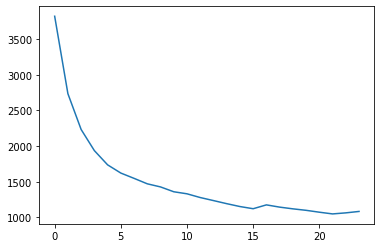

In [420]:
start=0
stop=24
plt.plot(range(len(current_file[start:stop])),current_file['rmse'][start:stop])

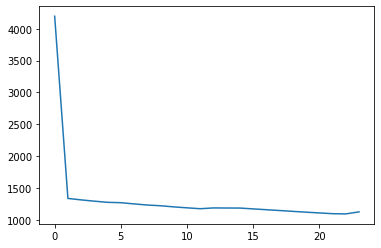

In [421]:
start=24
stop=start+24
plt.plot(range(len(current_file[start:stop])),current_file['rmse'][start:stop])

In [402]:
#checking output of lr.sample
n=24*2
m=1
start_prob = np.zeros(n)
start_prob[0] = 1
trans_mat = np.eye(n,k=1)
trans_mat[n-1,0] =1

lr = hmm.GaussianHMM(n_components=n,covariance_type='diag',init_params='cms',params='cmts')
#lr.startprob_ = start_prob
lr.transmat_ = trans_mat

lr.fit(train[train.index.month==m]['Mwh'].values.reshape(-1,1))
fy_pred_values, fy_pred_states = lr.sample(len(test))
fy_pred_values, fy_pred_states
#full_yr_df['predicted value'] = fy_pred_values
#full_yr_df['predicted state'] = fy_pred_states


(array([[23238.05248765],
        [19914.57332758],
        [20300.96472703],
        ...,
        [18603.87402492],
        [19510.35212562],
        [18942.68821198]]), array([10, 11, 12, ..., 45, 46, 47]))

In [406]:
columns = ['predicted_state','predicted_value','actual_value','squared error','rmse']
full_yr_df = pd.DataFrame(index = test.index,columns=columns)
full_yr_df['actual_value'] = test['Mwh']
full_yr_df['predicted value'] = fy_pred_values
full_yr_df['squared error'] = (full_yr_df['actual_value']-full_yr_df['predicted value'])**2
full_yr_df

,predicted_state,predicted_value,actual_value,squared error,rmse,predicted value
DateTime,,,,,,
2019-01-01 00:00:00,NaN,NaN,19586.0,1.333749e+07,NaN,23238.052488
2019-01-01 01:00:00,NaN,NaN,18891.0,1.047702e+06,NaN,19914.573328
2019-01-01 02:00:00,NaN,NaN,18198.0,4.422461e+06,NaN,20300.964727
2019-01-01 03:00:00,NaN,NaN,17423.0,2.311827e+06,NaN,18943.469300
2019-01-01 04:00:00,NaN,NaN,16613.0,1.661784e+04,NaN,16741.910199
...,...,...,...,...,...,...
2019-12-02 09:00:00,NaN,NaN,14631.0,2.085337e+06,NaN,13186.930248
2019-12-02 10:00:00,NaN,NaN,14872.0,1.116020e+06,NaN,15928.418649
2019-12-02 11:00:00,NaN,NaN,15709.0,8.380296e+06,NaN,18603.874025


In [408]:
#select best model
#calc rmse for 1hr ahead
#calc rmse for 1 year = sample
#train model with pre-defined transition and start and run various n on validation
columns = ['predicted_state','predicted_value','lookback_predicted_state','actual_value','squared error','rmse']
final_df = pd.DataFrame(index = test.index,columns=columns)
final_df['actual_value'] = test['Mwh']

columns = ['predicted_state','predicted_value','actual_value','squared error','rmse']
full_yr_df = pd.DataFrame(index = test.index,columns=columns)
full_yr_df['actual_value'] = test['Mwh']

full_yr_se_list = []

n = 24*30

se = []
actual_list = []

for m in range(1,13):
    days_in_month = max(test[test.index.month==m].index.day)

    start_prob = np.zeros(n)
    start_prob[0] = 1
    trans_mat = np.eye(n,k=1)
    trans_mat[n-1,0] =1

    lr = hmm.GaussianHMM(n_components=n,covariance_type='diag',init_params='cms',params='cmts')
    #lr.startprob_ = start_prob
    lr.transmat_ = trans_mat

    lr.fit(train[train.index.month==m]['Mwh'].values.reshape(-1,1))
    fy_pred_values, fy_pred_states = lr.sample(len(test))
    full_yr_df['predicted value'] = fy_pred_values
    full_yr_df['predicted state'] = fy_pred_states


    #ungrouped evaluation, 1 time step

    for d in range(1,days_in_month+1):
        #first prediction of model = pred_t. we hardcode because we sample
        pred_value, pred_state = lr.sample(1)
        final_df['predicted_value'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = pred_value[0][0]
        final_df['predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = pred_state[0]
        actual_value = val[val.index == datetime(year =2018, month=m, day = d, hour = 0)]['Mwh'].values[0]
        actual_list.append(actual_value)
        se.append((pred_value[0][0]-actual_value)**2)
        final_df['squared error'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = (pred_value[0][0]-actual_value)**2
        final_df['rmse'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = np.sqrt((pred_value[0][0]-actual_value)**2)
        
        full_yr_df['rmse'][full_yr_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = full_yr_df['squared error'][full_yr_df.index == datetime(year =2018, month=m, day = d, hour = 0)].pow(0.5)
        full_yr_se_list.append(full_yr_df['squared error'][full_yr_df.index == datetime(year =2018, month=m, day = d, hour = 0)])

        #print('predicted @ t:',pred_value[0][0], pred_state[0],'actual value:',actual_value)

        #update model for actual value
        #lookback_pred_state = lr.predict(actual_value.reshape(1,-1))[0]
        lookback_pred_state = np.argmin(abs(lr.means_-actual_value))
        final_df['lookback_predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = 0)] = np.argmin(abs(lr.means_-actual_value))
        #print('lookback pred state:',lookback_pred_state,'value: ',lr.means_[lookback_pred_state])

        for hr in range(1,24):
            #predict t+1 using lookback
            pred_state = np.argmax(lr.transmat_[lookback_pred_state])
            final_df['predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = pred_state
            #print('trans matrix row of state ',lookback_pred_state,' is ',lr.transmat_[lookback_pred_state])
            pred_value = lr.means_[pred_state][0]
            final_df['predicted_value'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = lr.means_[pred_state][0]
            actual_value = val[val.index == datetime(year =2018, month=m, day = d, hour = hr)]['Mwh'].values[0]
            actual_list.append(actual_value)
            se.append((pred_value-actual_value)**2)
            final_df['squared error'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = (pred_value-actual_value)**2
            final_df['rmse'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = np.sqrt(np.mean(se))
            #print('predicted state t+1:',pred_state,'predicted value:',pred_value, 'actual value:',actual_value)
            full_yr_se_list.append(full_yr_df['squared error'][full_yr_df.index == datetime(year =2018, month=m, day = d, hour = hr)])
            full_yr_df['rmse'][full_yr_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = np.sqrt(np.mean(full_yr_se_list))

            #update model for actual value
            #lookback_pred_state = lr.predict(np.array(actual_list).reshape(-1,1))[hr]
            lookback_pred_state = np.argmin(abs(lr.means_-actual_value))
            final_df['lookback_predicted_state'][final_df.index == datetime(year =2018, month=m, day = d, hour = hr)] = np.argmin(abs(lr.means_-actual_value))
            #print('lookback pred state:',lookback_pred_state,'value: ',lr.means_[lookback_pred_state])

        #print('rmse: ',np.sqrt(np.mean(se)))
#save each model
ext = '/ungrouped_st_'+str(n)
dirName = '/Users/gregscanlon/Documents/NYU/ts_electricity/test_set_scores'

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

os.chdir(dirName)

file_name = '1hr_ungrouped_st_'+str(n)+'.pkl'
with open(file_name, "wb") as file: 
    pickle.dump(final_df, file)
    
file_name = 'full_yr_ungrouped_st_'+str(n)+'.pkl'
with open(file_name, "wb") as file: 
    pickle.dump(full_yr_df, file)

    


KeyboardInterrupt: 

In [286]:
#grouped by mean evaluation
se = []
actual_list = []
d=19
#first prediction of model = pred_t
pred_value, pred_state = lr.sample(1)
actual_value = val_ymdh.loc[1,d,0][0]
actual_list.append(actual_value)
se.append((pred_value[0][0]-actual_value)**2)

print('predicted @ t:',pred_value[0][0], pred_state[0],'actual value:',actual_value)

#update model for actual value
lookback_pred_state = lr.predict(actual_value.reshape(1,-1))[0]
print('lookback pred state:',lookback_pred_state)

for hr in range(1,24):
    #predict t+1 using lookback
    pred_state = np.argmax(lr.transmat_[lookback_pred_state])
    #print('trans matrix row of state ',lookback_pred_state,' is ',lr.transmat_[lookback_pred_state])
    pred_value = lr.means_[pred_state]
    actual_value = val_ymdh.loc[1,d,hr][0]
    actual_list.append(actual_value)
    se.append((pred_value-actual_value)**2)
    print('predicted state t+1:',pred_state,'predicted value:',pred_value, 'actual value:',actual_value)
    
    #update model for actual value
    lookback_pred_state = lr.predict(val_ymdh.loc[1,d,0:hr]['Mwh'].values.reshape(-1,1))[hr]
    print('lookback pred state:',lookback_pred_state)
    
print('rmse: ',np.sqrt(np.mean(se)))

AttributeError: Cannot access callable attribute 'loc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [194]:
se = []
d=31
#first prediction of model = pred_t
pred_state = model_dict[1,d].sample(1)

pred_value = model_dict[1,d].means_[pred_state]
actual_value = val_ymdh.loc[1,31,0]
se.append((pred_value-actual_value)**2)

#update model for actual value
lookback_pred_state = model_dict[1,d].predict(val_ymdh.loc[1,31,0])

#pred_t+1
pred_state = np.argmax(model_dict[1,d].transmat_[lookback_pred_state])
pred_value = model_dict[1,d].means_[pred_state]
actual_value = val_ymdh.loc[1,31,1]
se.append((pred_value-actual_value)**2)

IndexError: arrays used as indices must be of integer (or boolean) type

In [174]:
d=31
x, z = model_dict[1,d].sample(24)
val_x = val_ymdh.loc[1,d].to_numpy()
np.sqrt(np.mean((x-val_x)**2))

3029.8357016477567

In [175]:
d=30
x, z = model_dict[1,d].sample(24)
val_x = val_ymdh.loc[1,d].to_numpy()
np.sqrt(np.mean((x-val_x)**2))

2614.17957902399

In [176]:
d=29
x, z = model_dict[1,d].sample(24)
val_x = val_ymdh.loc[1,d].to_numpy()
np.sqrt(np.mean((x-val_x)**2))

2543.6595158089813

In [65]:
#RMSE calc for January.  Need to check if my calc of sigma squared is ok
np.sqrt(((score_dict[1]+31/2*np.log(2*np.pi*np.mean(covars_dict[1])))*-2*np.mean(covars_dict[1]))/31)

631.6588029569372

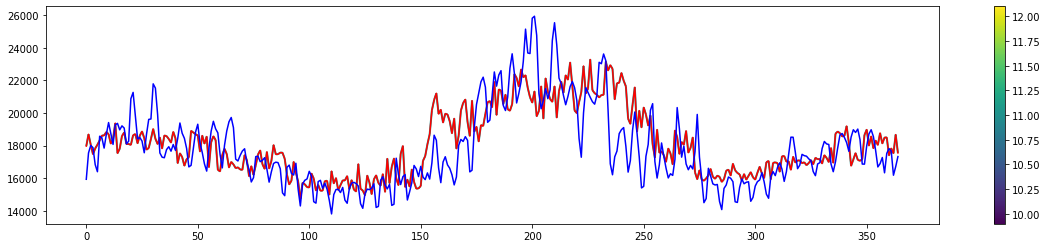

In [28]:
#plot results of each model by month vs test data
month_length_in_days = []
concat_samples = []
for i in range(1,len(times.groupby(times.month))+1):
    month_length_in_days.append(times.groupby(times.month)[i].days_in_month[0])
    days = times.groupby(times.month)[i].days_in_month[0]
    for d in range(days):
        concat_samples.append(int(sample_x_dict[i][d]))
    
test_len = len(test_ymd)
x = np.arange(np.sum(np.asarray(month_length_in_days)))[0:test_len]
y = np.asarray(concat_samples)[0:test_len]
month = np.asarray(times.month)[0:test_len]

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(month)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.plot(x,y,c='r')
ax.plot(x, test_ymd,c='b')

plt.title('Daily avg: projected vs actual')
plt.savefig()
plt.show()

In [27]:
df_ymd.loc[4].shape

(30, 1)

In [ ]:
#adjust data for multiple sequences
X = np.concatenate([X1, X2])
lengths = [len(X1), len(X2)]

In [120]:
times = pd.DatetimeIndex(data.index)
df_ymdh = data.groupby([times.month,times.day,times.hour]).mean()

In [254]:
#create hmm for each hour for 7 days for each month
#create train df sorted by year, month, day and summed by day
times_train = pd.DatetimeIndex(data.index)
df_ymdh = data.groupby([times_train.month,times_train.day,times_train.hour]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour]).mean()
n=31

months = [12,1,2,3,4,5,6,7,8,9,10,11]
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
for i in range(1,13):
    days = times.groupby(times.month)[i].days_in_month[0]
    for d in range(1,days+1):
        #print(i,d)
        model = hmm.GaussianHMM(n_components=4,n_iter=10)
        tr = df_ymdh['demand'][i][d].values.reshape(-1,1)
        te = test_ymdh['demand'][i][d].values.reshape(-1,1)
        model.fit(tr)
        conv_dict[i,d] = model.monitor_.converged
        score_dict[i,d] = model.score(te)
        states_dict[i,d] = model.predict(tr)
        means_dict[i,d] = model.means_
        covars_dict[i,d] = model.covars_
        sample_x_dict[i,d], sample_z_dict[i,d] = model.sample(len(te))

In [255]:
score_dict

{(1, 1): -268.1654332911509,
 (1, 2): -225.17166713472903,
 (1, 3): -215.3992029927925,
 (1, 4): -208.02834369205613,
 (1, 5): -279.6021399195384,
 (1, 6): -433.21199046475334,
 (1, 7): -251.10398942397666,
 (1, 8): -224.81542798068776,
 (1, 9): -242.240964554165,
 (1, 10): -202.39663064102075,
 (1, 11): -223.46758668957878,
 (1, 12): -210.1435185279128,
 (1, 13): -213.42078926240907,
 (1, 14): -199.0512544245596,
 (1, 15): -203.88080938628855,
 (1, 16): -204.98555738204766,
 (1, 17): -209.61338301902114,
 (1, 18): -196.7723660510268,
 (1, 19): -277.25995839650767,
 (1, 20): -202.6853577857606,
 (1, 21): -344.99035972606424,
 (1, 22): -462.68173142123527,
 (1, 23): -270.81159322481034,
 (1, 24): -198.72147254966012,
 (1, 25): -196.72878827463452,
 (1, 26): -272.0295370049673,
 (1, 27): -205.2513049853491,
 (1, 28): -218.74360781928024,
 (1, 29): -261.39086316220886,
 (1, 30): -248.57613683897245,
 (1, 31): -447.90180913421483,
 (2, 1): -390.6904347853881,
 (2, 2): -223.4441821358519,
 

In [262]:
sample_x_dict[1,1]

array([[20848.17874146],
       [19811.78033036],
       [19528.95381786],
       [18712.42759702],
       [19557.98943149],
       [19752.03331976],
       [20396.31382554],
       [21015.437856  ],
       [20126.02197217],
       [17422.15460646],
       [16550.11009351],
       [16158.45223197],
       [15191.30216553],
       [14969.68250596],
       [15543.31320831],
       [15398.82440653],
       [15224.48555263],
       [15698.81004413],
       [15956.13290839],
       [16047.45989403],
       [15028.03952746],
       [15743.13208503],
       [15371.09405904],
       [15665.41171324]])

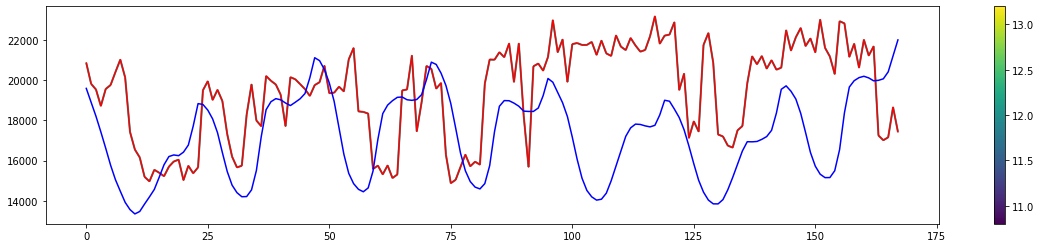

In [271]:
#plot results of each model by month/day/hour vs test data
month_length_in_days = []
concat_samples = []
for k in sample_x_dict.keys():
    for h in range(len(sample_x_dict[k])):
        concat_samples.append(int(sample_x_dict[k][h]))
    
#test_len = len(test_ymdh)
test_len = 24*7
x = np.arange(test_len)
y = np.asarray(concat_samples)[0:test_len]
month = np.asarray(times.month)[0:test_len]

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(month)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.plot(x,y,c='r')
ax.plot(x, test_ymdh[0:test_len],c='b')


plt.show()

In [175]:
test_ymdh

18508.0

In [177]:
times_test.hour[start:25]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64')

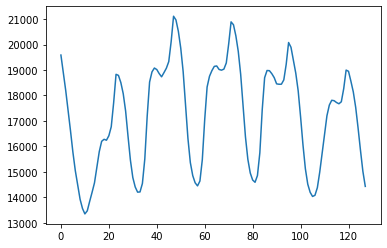

In [179]:
start = 0
end = 128
plt.plot(range(end),test_ymdh['demand'][start:end].values)

In [3]:
#OLD

#start_date = datetime(2015,7,1,5)
train_start_dt = dt_list[-1]
train_end_dt = dt_list[365*24]
if train_end_dt.day != 30:
    add_days = ((30 - train_end_dt.day)*24)
    train_end_dt = dt_list[(365*24)-add_days]
if train_end_dt.hour != 23:
    add_days += 23-train_end_dt.hour
    train_end_dt = dt_list[(365*24)-add_days]
test_start_dt = dt_list[(365*24)-add_days-1]
print('train_end:',train_end_dt,'test_start:',test_start_dt)
#test_start_dt = datetime(2018,11,1,0,tzinfo=utc)
#train_start_dt, train_end_dt, test_start_dt
test_start_dt = date.today()-timedelta(days=365,hours=datetime.today().hour)
train_end_dt = datetime.fromisoformat('2011-11-04')
test = data_NY.loc[data_NY.index[0]:test_start_dt]
train = data_NY.loc[test.index[-1]:train_start_dt]
data = train
data = data_NY.loc[train_end_dt:train_start_dt]
data = data.iloc[::-1]
test = data_NY.loc[data_NY.index[0]:test_start_dt]
test = test.iloc[::-1]
n=len(test)
n

train_end: 2018-11-30 23:00:00+00:00 test_start: 2018-12-01 00:00:00+00:00


In [ ]:
#compare the predicted values (predicted states shown by colormap) vs the actual test
#MAYBE THE BEST WAY TO FIT THIS IS BY MOVING AVERAGE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

i = months[0]
states = 2
start = 0

#end = len(test_dict['month'])
end = len(test_month_dict[i])
y = sample_x_dict[i][start:end].ravel()
x = np.arange(end)
#y2 = test_dict[i][start:end]
y2 = np.asarray(test_month_dict[i])
y3 = np.asarray(train_month_dict[i][start:end])
#y4 = train_dict[i][end+1:-1]
st = np.asarray(sample_z_dict[i][start:end])

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
ax.plot(x, y2,c='black')
ax.plot(x, y3,c='r')
#ax.plot(x, y4,c='g')

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y2.min(), y2.max())
ax.set_title('test '+str(i)+ total states & '+str(len(np.unique(st)))+' unique states used here')

plt.show()

In [ ]:
#create hmm for each month
#data.groupby(times.month).values
times = pd.DatetimeIndex(data.index)
data[times.month==1]

#create HMM for each month
hmm_dict = {}
#hmm_list = ['hour','day','month']
hmm_list = ['month']
m_states = [2,]
hmm_states = [m_states]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
for i in months:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)

In [8]:
#transform data to fit hierarchical HMMs
train_dict = {}
#create daily
times = pd.DatetimeIndex(data.index)
#df.groupby(times.hour)
#data.loc[data_NY.index[0]:data_NY.index[50]].groupby(times.hour).mean()


#create ~2month mean
train_dict['1095_hrs'] = np.mean(train.reshape(-1,1095),axis=1).reshape(-1,1)
train_dict['3504_hrs'] = np.mean(train.reshape(-1,3504),axis=1).reshape(-1,1)

#create monthly
train_dict['month'] = (data.groupby([times.year,times.month]).mean().values)[0:12]

#limit the trainig to just a 24hour cycle for more precise learning
#train on just the residuals
train_dict['hour'] = (data.groupby([times.day,times.hour]).mean().values)[0:48]-np.mean(train_dict['month'])

#create weekly
#limit the training to just a 7 day cycle for more precise learning
#train on just the residuals
train_dict['day'] = (data.groupby([times.month,times.day]).mean().values)[0:14]-np.mean(train_dict['month'])



test_dict = {}
#create daily
times = pd.DatetimeIndex(test.index)
#df.groupby(times.hour)
#data.loc[data_NY.index[0]:data_NY.index[50]].groupby(times.hour).mean()
test_dict['hour'] = test.groupby([times.day,times.hour]).mean().values-np.mean(train_dict['month'])

#create weekly
test_dict['day'] = test.groupby([times.month,times.day]).mean().values-np.mean(train_dict['month'])

#create monthly
#drop final month because it is a partial
times = pd.DatetimeIndex(test.index)
test_dict['month'] = (test.groupby([times.year,times.month]).mean().values)[0:11]


test_dict['1095_hrs'] = np.mean(test_arr.reshape(-1,1678),axis=1).reshape(-1,1)
test_dict['3504_hrs'] = np.mean(test_arr.reshape(-1,4195),axis=1).reshape(-1,1)
#label = test_dict['month'].index[12]
#test_dict['month'].drop(label,inplace=True)

ValueError: cannot reshape array of size 29971 into shape (1095)

In [ ]:
type(train_dict['month'][0][0])

In [ ]:
hmm_dict = {}
hmm_list = ['1095_hrs','3504_hrs']
hmm_states = [4,8,16,24]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
for i in hmm_idx:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)

In [ ]:
#create HMM for each group
hmm_dict = {}
#hmm_list = ['hour','day','month']
hmm_list = ['month']
m_states = 3
hmm_states = [m_states]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
conv_dict = {}
score_dict = {}
states_dict = {}
means_dict = {}
covars_dict = {}
sample_x_dict = {}
sample_z_dict = {}
for i in hmm_idx:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)
    
hmm_list = ['day']
hmm_states = [3,7]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
for i in hmm_idx:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)
    
hmm_list = ['hour']
hmm_states = [4,24]
#hmm_idx = zip_longest(hmm_list,hmm_states)
hmm_idx = product(hmm_list,hmm_states)
for i in hmm_idx:
    print(i)
    model = hmm.GaussianHMM(n_components=i[1],n_iter=10)
    model.fit(train_dict[i[0]])
    conv_dict[i] = model.monitor_.converged
    score_dict[i] = model.score(test_dict[i[0]])
    states_dict[i] = model.predict(train_dict[i[0]])
    means_dict[i] = model.means_
    covars_dict[i] = model.covars_
    sample_x_dict[i], sample_z_dict[i] = model.sample(n)

In [54]:
score_dict

{1: -284.8874929709642,
 2: -290.2623390514509,
 3: -358.29111382200995,
 4: -260.4511871439744,
 5: -267.6301155313911,
 6: -266.2199565485274,
 7: -371.6434763696666,
 8: -427.60740421935395,
 9: -296.4054106285989,
 10: -477.9098976379624,
 11: -205.26063852327582,
 12: -245.56507413131135}

In [2]:
#OLD. 

api_key = "b69eaad26ff420f24653c4f0cdfd02d6"

series_id = 'SEDS.TETCB.NY.A'
'EBA.NY-ALL.D.H'

url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.H".format(api_key)

response = requests.get(url)
response.json()
data_arr = np.asarray(response.json()['series'][0]['data'])
dt_list = []
for i in range(len(data_arr)):
    dt_list.append(parser.parse(data_arr[i][0]))
# Format data so that it has a datetime index
data_arr = np.asarray(response.json()['series'][0]['data'])
dt_list = []
for i in range(len(data_arr)):
    dt_list.append(parser.parse(data_arr[i][0]))
data_NY = pd.DataFrame(data=data_arr[:,1], index=dt_list)

# Prep the demand column
data_NY.columns = ['demand']
data_NY.demand = pd.to_numeric(data_NY.demand)

# Clean data to replace zeros as missing
data_NY.demand = data_NY.demand.replace(0,np.nan).interpolate()

In [ ]:
st_mu = np.zeros(len(states_dict[4]))
st_mu = np.where(states_dict[4]==0,means_dict[4][0],np.where(states_dict[4]==1,means_dict[4][1],np.where(states_dict[4]==2,means_dict[4][2],means_dict[4][3])))

In [ ]:
train_dict['month'].shape, end

In [52]:
sample_x_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

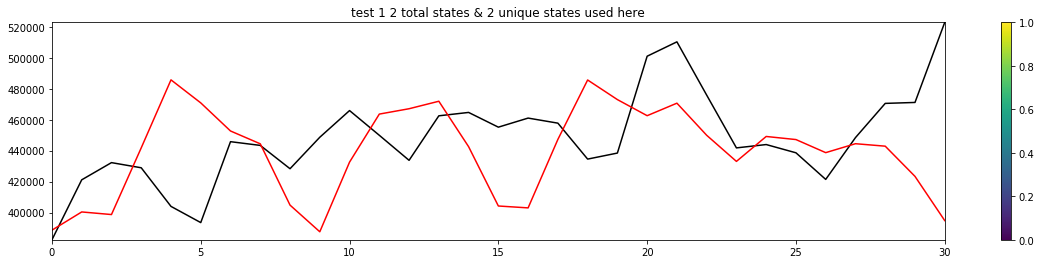

In [53]:
#compare the predicted values (predicted states shown by colormap) vs the actual test
#MAYBE THE BEST WAY TO FIT THIS IS BY MOVING AVERAGE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

i = months[0]
states = 2
start = 0

#end = len(test_dict['month'])
end = len(test_month_dict[i])
y = sample_x_dict[i][start:end].ravel()
x = np.arange(end)
#y2 = test_dict[i][start:end]
y2 = np.asarray(test_month_dict[i])
y3 = np.asarray(train_month_dict[i][start:end])
#y4 = train_dict[i][end+1:-1]
st = np.asarray(sample_z_dict[i][start:end])

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)
ax.plot(x, y2,c='black')
ax.plot(x, y3,c='r')
#ax.plot(x, y4,c='g')

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y2.min(), y2.max())
ax.set_title('test '+str(i)+' '+str(states)+' total states & '+str(len(np.unique(st)))+' unique states used here')

plt.show()

In [ ]:
d = 'day'
states = 7
start = 0
end = len(test_dict[d])
x = np.arange(end)
y = sample_x_dict[d,states][start:end].ravel()
y2 = test_dict[d][start:end]
st = sample_z_dict[d,states][start:end]

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig2, ax2 = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc2 = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc2.set_array(st)
lc2.set_linewidth(2)
line2 = ax2.add_collection(lc2)
fig.colorbar(line2, ax=ax2)
ax2.plot(x, y2,c='black')

ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y2.min(), y2.max())
ax2.set_title('test '+str(d)+' '+str(states)+' total states & '+str(len(np.unique(st)))+' unique states used here')

plt.show()

In [ ]:
h = 'hour'
states = 24
start = 0
end = len(test_dict[h])
end=48
x = np.arange(end)
y = sample_x_dict[h,states][start:end].ravel()
y2 = test_dict[h][start:end]
st = sample_z_dict[h,states][start:end]

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig2, ax2 = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc2 = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc2.set_array(st)
lc2.set_linewidth(2)
line2 = ax2.add_collection(lc2)
fig.colorbar(line2, ax=ax2)
ax2.plot(x, y2,c='black')

ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y2.min(), y2.max())
ax2.set_title('test '+str(h)+' '+str(states)+' total states & '+str(len(np.unique(st)))+' unique states used here')

plt.show()

In [ ]:
h = 'hour'
h_states = 24
d = 'day'
d_states=7
m = 'month'
m_states = 12
sample_x_dict[h,h_states][0], sample_x_dict[d,d_states][0],sample_x_dict[m,m_states][0]

In [ ]:
#create hierarchy
hmm_states = [12]
hierarch_pred = []
hmm_idx = product(range(12),range(30),range(24))
for idx in hmm_idx:
    #print('m: ',sample_x_dict[m,m_states][int(idx[0])])
    
    #print('d: ',sample_x_dict[d,d_states][int(idx[1]*((idx[0])+1))])
    
    #print('h: ',sample_x_dict[h,h_states][int(idx[2]+idx[1]*((idx[0])+1))])
    #print(str(len(hierarch_pred)+1)+'est: ',sample_x_dict[m,m_states][int(idx[0])]+sample_x_dict[d,d_states][int(idx[1]*((idx[0])+1))]+sample_x_dict[h,h_states][int(idx[2]+idx[1]*((idx[0])+1))])
    hierarch_pred.append(sample_x_dict[m,m_states][int(idx[0])]+sample_x_dict[d,d_states][int(idx[1]*((idx[0])+1))]+sample_x_dict[h,h_states][int(idx[2]+idx[1]*((idx[0])+1))])
    

In [ ]:
len(hierarch_pred), len(test)

In [ ]:
#plot hierarchical predictions vs test data
# is the test year just very different from the train years? that is what it appears to be. confirm with charles on his graphs.

#sample from model 3 and compare to test
i  = 3
fig ,ax = plt.subplots(figsize=(20,4), sharex=True, sharey=True)
x = np.arange(len(test))
#ax.plot(x, hierarch_pred[0:len(test)],c='b')
#ax.plot(x, test,c='r')
train = data.to_numpy()
#ax.plot(x, train[0:len(test)],c='y')
ax.plot(x[2500:4500], train[len(test)+1:(len(test)*2)+1][2500:4500],c='g')
ax.plot(x[2600:2624], train[len(test)+1:(len(test)*2)+1][2600:2624],c='y')
#ax.set_xlim(x.min(), x.max())
#ax.set_ylim((train.min()), train.max())
plt.show()

In [ ]:
#see the trained states
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

i = 'hour'
states = 12
start = 0
end = 348

y = train_dict[i].ravel()
x = np.arange(len(y))
st = states_dict[i,states]

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = n
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = states_dict[3][st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = n
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = states_dict[3][st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 9000
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = states_dict[4][st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(20, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 1000
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
st = st_mu[st:end] 

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(18, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis')
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title('4 states by mu')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

st = 0
end = 250
x = np.arange(end)
y = data.to_numpy()[st:end].ravel()
#st = states_dict[3][st:end] 
st = st_mu[st:end]

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(18, 4))

# Create a continuous norm to map from data points to colors
#norm = plt.Normalize(dydx.min(), dydx.max())
cmap = ListedColormap(['r', 'g', 'b'])
lc = LineCollection(segments, cmap=cmap)
# Set the values used for colormapping
lc.set_array(st)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title(str(st.max()+1)+' states')
plt.show()

In [ ]:
len(test),n

In [ ]:
#sample from model 3 and compare to test
i  = 3
fig ,ax = plt.subplots(figsize=(20,4), sharex=True, sharey=True)
x = np.arange(n)
ax.plot(x, sample_x_dict[i],c='b')
ax.plot(x, test,c='r')
ax.set_xlim(x.min(), x.max())
ax.set_ylim((sample_x_dict[i].min()-100), sample_x_dict[i].max()+100)
plt.show()

In [ ]:
#sample from model 13 and compare to test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [ ]:
from hmmlearn.hmm import MultinomialHMM
data = data_NY.loc[train_end_dt:train_start_dt]
test = data_NY.loc[test_start_dt].to_numpy().reshape(-1,1)
mult_conv_dict = {}
mult_score_dict = {}
mult_states_dict = {}
mult_means_dict = {}
mult_covars_dict = {}
for i in range(14,30):
    model = hmm.MultinomialHMM(n_components=i,n_iter=10)
    model.fit(data)
    mult_conv_dict[i] = model.monitor_.converged
    mult_score_dict[i] = model.score(test)
    mult_states_dict[i] = model.predict(data)
    mult_means_dict[i] = model.means_
    mult_covars_dict[i] = model.covars_